In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pycaret import regression
from sklearn.model_selection import cross_val_score

In [3]:
df = pd.read_csv('Dataset/URLdatasetX2.csv')

In [4]:
df.head()

,url,type
0,http://www.crestonwood.com/router.php,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,phishing
2,https://support-appleld.com.secureupdate.duila...,phishing
3,http://rgipt.ac.in,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,legitimate


In [5]:
df.tail()

,url,type
11425,http://www.fontspace.com/category/blackletter,legitimate
11426,http://www.budgetbots.com/server.php/Server%20...,phishing
11427,https://www.facebook.com/Interactive-Televisio...,legitimate
11428,http://www.mypublicdomainpictures.com/,legitimate
11429,http://174.139.46.123/ap/signin?openid.pape.ma...,phishing


In [6]:
df.shape

(11430, 2)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11430 entries, 0 to 11429
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   url     11430 non-null  object
 1   type    11430 non-null  object
dtypes: object(2)
memory usage: 178.7+ KB


In [8]:
df.dtypes

url     object
type    object
dtype: object

In [9]:
from sklearn.preprocessing import LabelEncoder

In [10]:
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
cat_cols

['url', 'type']

In [11]:
le = LabelEncoder()

encoded_data = le.fit_transform(df['type'])

print(encoded_data)

[0 1 1 ... 0 0 1]


In [12]:
df

,url,type
0,http://www.crestonwood.com/router.php,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,phishing
2,https://support-appleld.com.secureupdate.duila...,phishing
3,http://rgipt.ac.in,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,legitimate
...,...,...
11425,http://www.fontspace.com/category/blackletter,legitimate
11426,http://www.budgetbots.com/server.php/Server%20...,phishing
11427,https://www.facebook.com/Interactive-Televisio...,legitimate
11428,http://www.mypublicdomainpictures.com/,legitimate


In [13]:
df['type'] = encoded_data

In [14]:
df

,url,type
0,http://www.crestonwood.com/router.php,0
1,http://shadetreetechnology.com/V4/validation/a...,1
2,https://support-appleld.com.secureupdate.duila...,1
3,http://rgipt.ac.in,0
4,http://www.iracing.com/tracks/gateway-motorspo...,0
...,...,...
11425,http://www.fontspace.com/category/blackletter,0
11426,http://www.budgetbots.com/server.php/Server%20...,1
11427,https://www.facebook.com/Interactive-Televisio...,0
11428,http://www.mypublicdomainpictures.com/,0


In [15]:
df.isnull().any()

url     False
type    False
dtype: bool

In [16]:
df.dtypes

url     object
type     int32
dtype: object

In [17]:
class_counts = df['type'].value_counts()

print('Class distribution:')
print(class_counts)

Class distribution:
type
1    5717
0    5713
Name: count, dtype: int64


<AxesSubplot:xlabel='type', ylabel='count'>

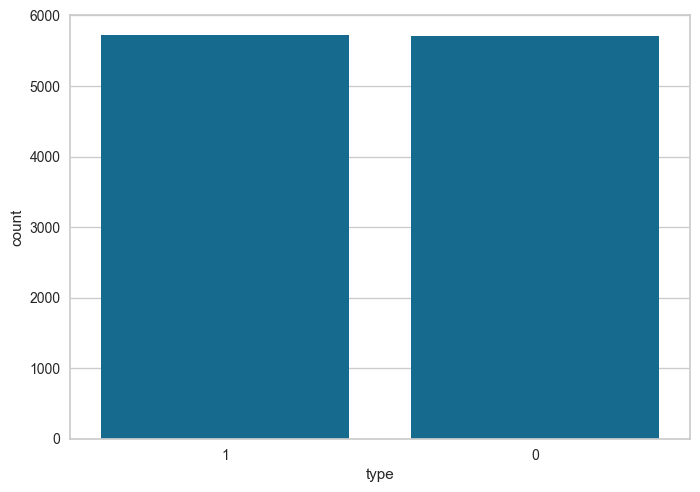

In [18]:
sns.countplot(x = 'type', data = df, order = df['type'].value_counts().index)

In [19]:
from transformers import BertModel, BertTokenizer
import torch

model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [20]:
def extract_features(text):
    input_ids = torch.tensor([tokenizer.encode(text, max_length=512, truncation=True, add_special_tokens=True)])
    with torch.no_grad():
        outputs = model(input_ids)
        hidden_states = outputs[2]
    token_vecs = []
    for layer in range(-4, 0):
        token_vecs.append(hidden_states[layer][0])
    features = []
    for token in token_vecs:
        features.append(torch.mean(token, dim=0))
    return torch.stack(features)

In [21]:
features = []
for i in range(len(df)):
    features.append(extract_features(df.iloc[i]["url"]))
features = torch.cat(features).numpy()

In [22]:
features

array([[ 0.3554541 , -0.4313164 ,  0.33785617, ..., -0.5239815 ,
         0.01528572,  0.2709864 ],
       [ 0.3375211 , -0.5219562 ,  0.3623771 , ..., -0.56649655,
        -0.10366118,  0.13471884],
       [ 0.24758734, -0.46600342,  0.33826882, ..., -0.4098953 ,
        -0.15380378,  0.15001947],
       ...,
       [ 0.1490057 ,  0.03284501,  0.7552326 , ..., -0.45253038,
        -0.23574644,  0.60932225],
       [ 0.34872296, -0.14546637,  0.70368534, ..., -0.4048883 ,
        -0.33061123,  0.7222575 ],
       [ 0.28205222, -0.13145377,  0.4980943 , ...,  0.04065904,
        -0.30997625,  0.2147622 ]], dtype=float32)

In [23]:
types = df['type'].values
types

array([0, 1, 1, ..., 0, 0, 1])

In [24]:
print(features.shape)
print(types.shape)

(45720, 768)
(11430,)


In [25]:
features_reshaped = features.reshape((11430, -1))

dataset = np.hstack((features_reshaped, types.reshape((-1, 1))))

In [26]:
features_reshaped.shape

(11430, 3072)

In [27]:
dataset

array([[ 0.35545409, -0.43131641,  0.33785617, ..., -0.20215441,
        -0.09798006,  0.        ],
       [ 0.31428623,  0.23424773,  0.59891027, ..., -0.1706956 ,
        -0.09488076,  1.        ],
       [ 0.131267  ,  0.11822309,  0.67833948, ..., -0.25263292,
         0.07201229,  1.        ],
       ...,
       [ 0.37019321, -0.01042262,  0.52551907, ..., -0.31032997,
         0.13075154,  0.        ],
       [ 0.31223592, -0.28647867,  0.42207995, ..., -0.30437118,
         0.02776907,  0.        ],
       [ 0.11018992, -0.03880708,  0.81239104, ..., -0.30997625,
         0.2147622 ,  1.        ]])

In [28]:
dataset.shape

(11430, 3073)

In [29]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

X_train, y_train = train_data[:, :-1], train_data[:, -1]
X_test, y_test = test_data[:, :-1], test_data[:, -1]

In [30]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

y_train_s = pd.Series(y_train)
y_train_res = pd.Series (y_train_res)
print('Class distribution before resampling:', y_train_s.value_counts())
print('Class distribution after resampling:', y_train_res.value_counts())

Class distribution before resampling: 1.0    4586
0.0    4558
Name: count, dtype: int64
Class distribution after resampling: 1.0    4586
0.0    4586
Name: count, dtype: int64


In [31]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

rf_score = rf.score(X_test, y_test)
print("Accuracy:", rf_score)

Accuracy: 0.9129483814523185


In [32]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(max_depth=4,learning_rate=0.7)
gbc.fit(X_train,y_train)

gbc_score = gbc.score(X_test, y_test)
print("Accuracy:", gbc_score)

Accuracy: 0.9103237095363079


In [33]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', C=1)
svm.fit(X_train, y_train)

svm_score = svm.score(X_test, y_test)
print("Accuracy:", svm_score)

Accuracy: 0.9304461942257218


In [34]:
y_pred_rf = rf.predict(X_test)
y_pred_gbc = gbc.predict(X_test)
y_pred_svm = svm.predict(X_test)

In [35]:
type(X_test)
X_test.shape

(2286, 3072)

In [36]:
pred = extract_features("http://www.824555.com/app/member/SportOption.php?uid=guest&langx=gb").numpy()
pred = np.reshape(pred, (1, 3072))
rf.predict(pred)

array([1.])

In [37]:
from sklearn.metrics import confusion_matrix, classification_report

In [38]:
rf_cm = confusion_matrix(y_test, y_pred_rf)
rf_cm = classification_report(y_test, y_pred_rf)

print("Confusion Matrix:\n", rf_cm)
print("\nClassification Report:\n", rf_cm)

Confusion Matrix:
               precision    recall  f1-score   support

         0.0       0.90      0.94      0.92      1155
         1.0       0.93      0.89      0.91      1131

    accuracy                           0.91      2286
   macro avg       0.91      0.91      0.91      2286
weighted avg       0.91      0.91      0.91      2286


Classification Report:
               precision    recall  f1-score   support

         0.0       0.90      0.94      0.92      1155
         1.0       0.93      0.89      0.91      1131

    accuracy                           0.91      2286
   macro avg       0.91      0.91      0.91      2286
weighted avg       0.91      0.91      0.91      2286



In [39]:
gbc_cm = confusion_matrix(y_test, y_pred_gbc)
gbc_cr = classification_report(y_test, y_pred_gbc)

print("Confusion Matrix:\n", gbc_cm)
print("\nClassification Report:\n", gbc_cr)

Confusion Matrix:
 [[1064   91]
 [ 114 1017]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.90      0.92      0.91      1155
         1.0       0.92      0.90      0.91      1131

    accuracy                           0.91      2286
   macro avg       0.91      0.91      0.91      2286
weighted avg       0.91      0.91      0.91      2286



In [40]:
svm_cm = confusion_matrix(y_test, y_pred_svm)
svm_cr = classification_report(y_test, y_pred_svm)

print("Confusion Matrix:\n", svm_cm)
print("\nClassification Report:\n", svm_cr)

Confusion Matrix:
 [[1082   73]
 [  86 1045]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.94      0.93      1155
         1.0       0.93      0.92      0.93      1131

    accuracy                           0.93      2286
   macro avg       0.93      0.93      0.93      2286
weighted avg       0.93      0.93      0.93      2286



In [41]:
import pickle

# Save the model to a pickle file
with open('phishing_svm_model.pkl', 'wb') as file:
    pickle.dump(svm, file)

In [5]:
from transformers import BertModel, BertTokenizer
import torch
import pickle
import numpy as np

bert_model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load the SVM model from the pickle file
with open('phishing_svm_model.pkl', 'rb') as file:
    model = pickle.load(file)

def extract_features(url):
    input_ids = torch.tensor([tokenizer.encode(url, max_length=512, truncation=True, add_special_tokens=True)])
    with torch.no_grad():
        outputs = bert_model(input_ids)
        hidden_states = outputs[2]
    token_vecs = []
    for layer in range(-4, 0):
        token_vecs.append(hidden_states[layer][0])
    features = []
    for token in token_vecs:
        features.append(torch.mean(token, dim=0))
    return torch.stack(features)


url = "https://github.com/NikhilAMathew/Pest-Classification-and-Detection-System-using-Deep-Learning"
print("url: ", url)

feature = extract_features(url).numpy()
print("feature: ", feature)

pred = np.reshape(feature, (1, 3072))
res = model.predict(pred)

if res==0:
    decision = "safe"
else:
    decision = "phishing"

print("decision: ", decision)

url:  https://github.com/NikhilAMathew/Pest-Classification-and-Detection-System-using-Deep-Learning
feature:  [[ 0.01760951  0.04371358  0.15408775 ... -0.56890607 -0.02923369
   0.5810735 ]
 [-0.16320619  0.21546529  0.15733948 ... -0.41429707 -0.32610497
   0.57507676]
 [-0.18842828  0.04945989 -0.03690038 ... -0.482367   -0.4670664
   0.53803855]
 [-0.14304535  0.01124408 -0.12048671 ... -0.31369728 -0.3724724
   0.17614782]]
decision:  safe
